### Lab 1. Detección de Pishing

#### Miembros
- Fernanda Esquivel - 21542
- Andrés Montoya - 21552

#### Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/FerEsq/SDS-Lab-01)

# Parte 1: Ingeniería de características

In [277]:
import pandas as pd
import math
from urllib.parse import urlparse
import re
from sklearn.model_selection import train_test_split

## Exploración de datos

In [278]:
df = pd.read_csv('data/dataset_pishing.csv')

In [279]:
# 5 entries
df.head(5)

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [280]:
# count of legit and phishing
df['status'].value_counts()

status
legitimate    5715
phishing      5715
Name: count, dtype: int64

El dataset está balanceado. 

1. **¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?**
Analizar las url tiene muchas ventajas, entre ellas:
- Evita la descarga del sitio, el cual podría contener código malicioso.
- Es mucho más rápida al detectar en tiempo real.
- Es computacionalmente más eficaz ya que solo se deben procesar strings cortos.
2. **¿Qué características de una URL son más prometedoras para la detección de phishing?**
- Longitud de la url completa
- Longitud del dominio
- Cantidad de subdominios
- Cantidad o presencia de caracteres especiales
- Cantidad de números
- Cantidad de letras
- Protocolo
- Cantidad de directorios
- Presencia de parámetros
- Cantidad de parámetros
- IP en la url
- TDL
- Identificación de redirecciones (posee más de una url)
- Presencia de credenciales en la url (correo)
- Entropía

## Derivación de características

In [281]:
# get the url length
df['url_length'] = df['url'].apply(lambda x: len(x))

In [282]:
# get the domain length
df['domain_length'] = df['url'].apply(lambda x: len(x.split('/')[2]))

In [283]:
# get protocol
df['protocol'] = df['url'].apply(lambda x: x.split(':')[0])

In [284]:
# get the number of subdomains
df['subdomains'] = df['url'].apply(lambda x: len(x.split('/')[2].split('.')) - 2)

In [285]:
# get if the url has a special characters
special_characters = ['@', '-', '_', '%', '?', '=', '&', '.']
df['special_characters'] = df['url'].apply(lambda x: 1 if any(c in x for c in special_characters) else 0)

In [286]:
# get the number of special characters
df['special_characters_count'] = df['url'].apply(lambda x: sum(1 for c in x if c in special_characters))

In [287]:
# get the number of digits
df['digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x))

In [288]:
# get the number of letters
df['letters'] = df['url'].apply(lambda x: sum(c.isalpha() for c in x))

In [289]:
# get the number of directories, 
def get_directories(url: str):
    domain_and_directories = url.split('://', 1)[1].split('?')[0]
    directories = domain_and_directories.split('/')[1:]
    cleaned_directories = [d for d in directories if d != '']
    return cleaned_directories

In [290]:
def has_file_extension(url):
    dirs = get_directories(url)
    return any('.' in d for d in dirs)

In [291]:
# get if the url has a file extension
df['has_file_extension'] = df['url'].apply(lambda x: 1 if has_file_extension(x) else 0)

In [292]:
def count_file_extensions(url):
    dirs = get_directories(url)
    return sum(1 for dir in dirs if '.' in dir)

In [293]:
# get the number of file extensions
df['file_extension_count'] = df['url'].apply(count_file_extensions)

In [294]:
#cantidad de directorios
df['directories_count'] = df['url'].apply(lambda x: len(get_directories(x)))

In [295]:
#si hay y cantidad de parámetros
df['has_parameters'] = df['url'].apply(lambda x: 1 if '?' in x else 0)
df['parameters_count'] = df['url'].apply(lambda x: x.count('&') + 1 if '?' in x else 0)

In [296]:
#encontrar IP en la url
def has_ip(url):
    # Patrón para IPv4
    pattern = r'(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)'
    return 1 if re.search(pattern, url) else 0

In [297]:
df['has_ip'] = df['url'].apply(has_ip)

In [298]:
#encontrar TLD
def get_tld(url):
    domain = url.split('/')[2]
    return domain.split('.')[-1]

In [299]:
df['tld'] = df['url'].apply(get_tld)

In [300]:
#encontrar si hay redirecciones
df['has_multiple_urls'] = df['url'].apply(lambda x: 1 if x.count('//') > 1 else 0)

In [301]:
#encontrar si hay credenciales
def has_credentials(url):
    #buscar @ antes del dominio o patrones de email
    has_at = '@' in urlparse(url).netloc
    email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
    has_email = bool(re.search(email_pattern, url))
    return 1 if (has_at or has_email) else 0

In [302]:
df['has_credentials'] = df['url'].apply(has_credentials)

In [303]:
#obtener entropía
def calculate_entropy(url):
    #calcular frecuencia de cada carácter
    char_freq = {}
    for char in url:
        char_freq[char] = char_freq.get(char, 0) + 1
    
    #calcular entropía
    entropy = 0
    length = len(url)
    for freq in char_freq.values():
        probability = freq / length
        entropy -= probability * math.log2(probability)
    return entropy

In [304]:
df['entropy'] = df['url'].apply(calculate_entropy)

In [305]:
#mostrar primeras 5 lineas del dataset para visualizar los cambios
df.head(5)

,url,status,url_length,domain_length,protocol,subdomains,special_characters,special_characters_count,digits,letters,has_file_extension,file_extension_count,directories_count,has_parameters,parameters_count,has_ip,tld,has_multiple_urls,has_credentials,entropy
0,http://www.crestonwood.com/router.php,legitimate,37,19,http,1,1,3,0,30,1,1,1,0,0,0,com,0,0,3.787043
1,http://shadetreetechnology.com/V4/validation/a...,phishing,77,23,http,0,1,1,17,53,0,0,3,0,0,0,com,0,0,4.419864
2,https://support-appleld.com.secureupdate.duila...,phishing,126,50,https,3,1,13,19,88,0,0,2,1,3,0,com,0,0,4.753412
3,http://rgipt.ac.in,legitimate,18,11,http,1,1,2,0,13,0,0,0,0,0,0,in,0,0,3.461320
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate,55,15,http,1,1,4,0,45,0,0,2,0,0,0,com,0,0,4.097662


In [306]:
#guardar el dataset actualizado
df.to_csv('data/dataset_phishing_features.csv', index=False)

## Preprocesamiento

In [307]:
#legitimate = 0, phishing = 1
df['status'] = (df['status'] == 'phishing').astype(int)

In [308]:
#mostrar primeras 5 lineas del dataset para visualizar los cambios
df.head(5)

,url,status,url_length,domain_length,protocol,subdomains,special_characters,special_characters_count,digits,letters,has_file_extension,file_extension_count,directories_count,has_parameters,parameters_count,has_ip,tld,has_multiple_urls,has_credentials,entropy
0,http://www.crestonwood.com/router.php,0,37,19,http,1,1,3,0,30,1,1,1,0,0,0,com,0,0,3.787043
1,http://shadetreetechnology.com/V4/validation/a...,1,77,23,http,0,1,1,17,53,0,0,3,0,0,0,com,0,0,4.419864
2,https://support-appleld.com.secureupdate.duila...,1,126,50,https,3,1,13,19,88,0,0,2,1,3,0,com,0,0,4.753412
3,http://rgipt.ac.in,0,18,11,http,1,1,2,0,13,0,0,0,0,0,0,in,0,0,3.461320
4,http://www.iracing.com/tracks/gateway-motorspo...,0,55,15,http,1,1,4,0,45,0,0,2,0,0,0,com,0,0,4.097662


In [309]:
#guardar el dataset actualizado
df.to_csv('data/dataset_phishing_features.csv', index=False)

## Selección de Características

In [310]:
#elegir las características relevantes
selected_features = [
    'url',  #mantenemos la URL para referencia
    'status',  #variable objetivo
    'url_length',
    'domain_length',
    'protocol',
    'subdomains',
    'special_characters_count',
    'digits',
    'letters',
    'directories_count',
    'parameters_count',
    'has_ip',
    'tld',
    'has_multiple_urls',
    'has_credentials',
    'entropy'
]

In [311]:
#crear el nuevo dataset con las características seleccionadas
df_clean = df[selected_features]

In [312]:
#guardar el dataset limpio
df_clean.to_csv('data/dataset_phishing_features_clean.csv', index=False)

3. **¿Qué columnas o características fueron seleccionadas y por qué?**
* Medidas de longitud (url_length, domain_length): estas identifican URLs sospechosamente largas
* Características de dominio (protocol, subdomains, tld): estas analizan la estructura y seguridad del dominio
* Características de composición (special_characters_count, digits, letters): estas examinan los patrones de caracteres utilizados
* Características de estructura (directories_count, parameters_count): estas evalúan la complejidad de la URL
* Indicadores de seguridad (has_ip, has_multiple_urls, has_credentials): estas detectan prácticas sospechosas como el uso de IPs directas o redirecciones;
* Entropía: esta mide la aleatoriedad en la URL


Se eliminaron características redundantes como special_characters, has_parameters y has_file_extension, ya que sus versiones de conteo proporcionan información más detallada, resultando en un conjunto de características optimizado para identificar URLs maliciosas.

# Parte 2: Implementación

## Separación de datos

In [313]:
#leer el dataset limpio
df = pd.read_csv('data/dataset_phishing_features_clean.csv')


In [314]:
#separar los datos de prueba (30%)
train_val_data, test_data = train_test_split(df, test_size=0.30, random_state=42, stratify=df['status'])

In [315]:
#separar entrenamiento (55%) y validación (15%)
train_data, val_data = train_test_split(train_val_data, test_size=0.214, random_state=42, stratify=train_val_data['status'])

In [316]:
#guardar los datasets
train_data.to_csv('data/models/train_data.csv', index=False)
val_data.to_csv('data/models/val_data.csv', index=False)
test_data.to_csv('data/models/test_data.csv', index=False)

In [317]:
#verificar los tamaños de los conjuntos
print(f"Tamaño total del dataset: {len(df)}")
print(f"Tamaño del conjunto de entrenamiento: {len(train_data)} ({len(train_data)/len(df)*100:.1f}%)")
print(f"Tamaño del conjunto de validación: {len(val_data)} ({len(val_data)/len(df)*100:.1f}%)")
print(f"Tamaño del conjunto de prueba: {len(test_data)} ({len(test_data)/len(df)*100:.1f}%)")

Tamaño total del dataset: 11430
Tamaño del conjunto de entrenamiento: 6288 (55.0%)
Tamaño del conjunto de validación: 1713 (15.0%)
Tamaño del conjunto de prueba: 3429 (30.0%)


## Implementación

In [327]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [331]:
#cargar los datasets
train_data = pd.read_csv('data/models/train_data.csv')
val_data = pd.read_csv('data/models/val_data.csv')
test_data = pd.read_csv('data/models/test_data.csv')

In [332]:
#preparar los datos
categorical_columns = ['protocol', 'tld']
numeric_columns = [col for col in train_data.columns 
                    if col not in ['url', 'status'] + categorical_columns]

In [333]:
#crear el preprocesador usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ])

In [334]:
X_train = train_data[numeric_columns + categorical_columns]
y_train = train_data['status']

In [335]:
X_val = val_data[numeric_columns + categorical_columns]
y_val = val_data['status']

In [336]:
X_test = test_data[numeric_columns + categorical_columns]
y_test = test_data['status']

In [337]:
#aplicar el preprocesamiento
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

In [338]:
#función para evaluar el modelo
def evaluate_model(model, X, y, model_name):
    #predicciones
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    #matriz de confusión
    cm = confusion_matrix(y, y_pred)
    
    #calcular métricas ROC
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    #imprimir métricas
    print(f"\nResultados para {model_name}")
    print("\nMatriz de confusión:")
    print(cm)
    print("\nReporte de clasificación:")
    print(classification_report(y, y_pred))
    print(f"AUC-ROC: {roc_auc:.4f}")
    
    #visualizar matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Valor Real')
    plt.xlabel('Predicción')
    plt.show()
    
    #visualizar curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    return cm, roc_auc

### Random Forest


Resultados para Random Forest

Matriz de confusión:
[[1506  209]
 [ 238 1476]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1715
           1       0.88      0.86      0.87      1714

    accuracy                           0.87      3429
   macro avg       0.87      0.87      0.87      3429
weighted avg       0.87      0.87      0.87      3429

AUC-ROC: 0.9401


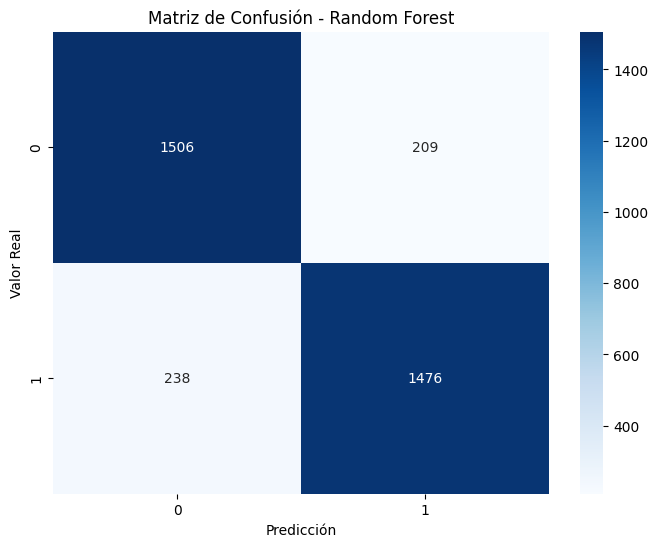

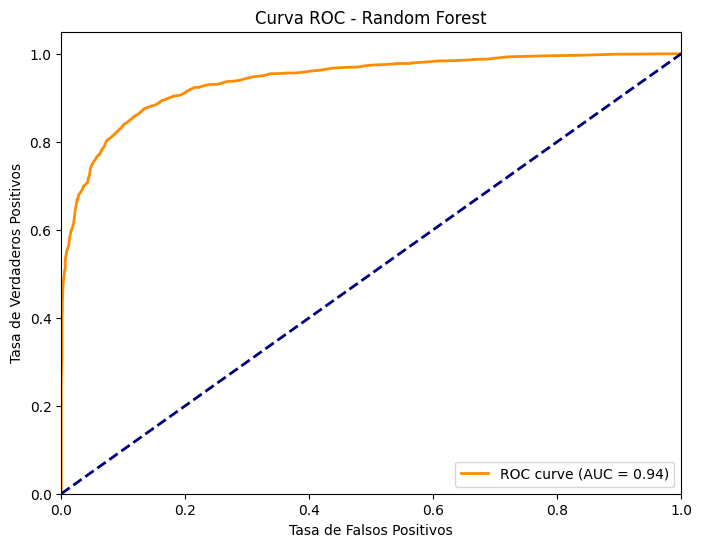

In [340]:
#entrenar y evaluar Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_transformed, y_train)
rf_cm, rf_auc = evaluate_model(rf_model, X_test_transformed, y_test, "Random Forest")

### Red Neuronal Multicapa (MLP)

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")



Resultados para MLP

Matriz de confusión:
[[1543  172]
 [ 278 1436]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1715
           1       0.89      0.84      0.86      1714

    accuracy                           0.87      3429
   macro avg       0.87      0.87      0.87      3429
weighted avg       0.87      0.87      0.87      3429

AUC-ROC: 0.9282


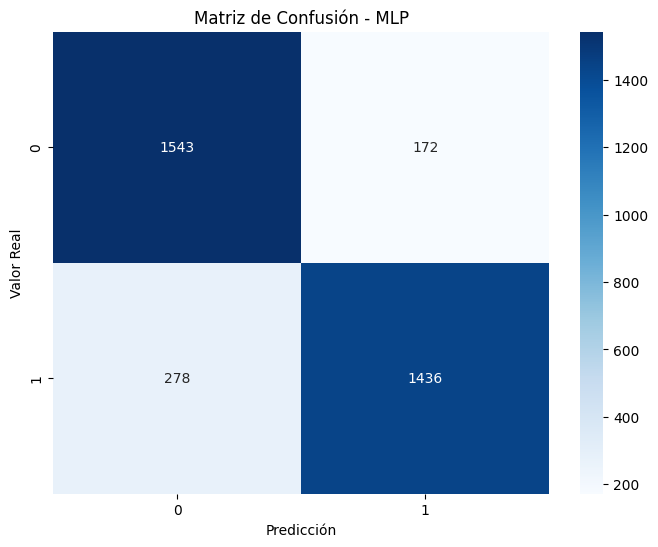

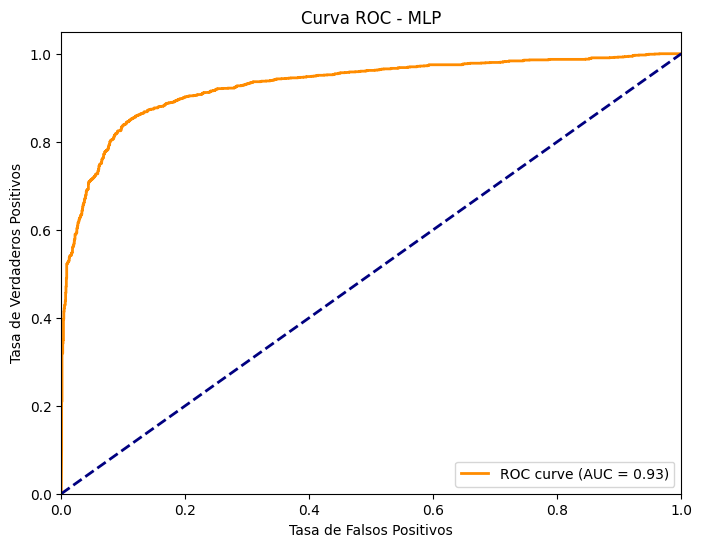

In [341]:
#entrenar y evaluar MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_model.fit(X_train_transformed, y_train)
mlp_cm, mlp_auc = evaluate_model(mlp_model, X_test_transformed, y_test, "MLP")

In [343]:
#guardar los modelos
joblib.dump(rf_model, 'models/random_forest_model.joblib')
joblib.dump(mlp_model, 'models/mlp_model.joblib')
joblib.dump(preprocessor, 'models/preprocessor.joblib')

['models/preprocessor.joblib']

## Discusión

4. **¿Cuál es el impacto de clasificar un sitio legítimo como phishing?**
* Clasificar un sitio legítimo como phishing (falso positivo) puede causar pérdidas económicas y de productividad para las organizaciones, ya que los usuarios no podrán acceder a recursos necesarios, además de generar frustración y posible pérdida de confianza en el sistema de detección.

5. **¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?**
* Clasificar un sitio de phishing como legítimo (falso negativo) es potencialmente más peligroso, ya que expone a los usuarios a ataques que podrían resultar en robo de credenciales, información personal o financiera, malware, y pérdidas económicas significativas, además de comprometer la seguridad de toda la organización si las credenciales robadas son utilizadas para accesos no autorizados.

6. **En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?**
* Dado que los falsos negativos son más peligrosos que los falsos positivos en este contexto, la métrica más apropiada sería el Recall (sensibilidad), ya que mide la capacidad del modelo para detectar correctamente los sitios de phishing, priorizando así la seguridad sobre la conveniencia, aunque también sería importante considerar el F1-score para mantener un balance con la precisión.


7. **¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?**
* Comparando los resultados de ambos modelos, aunque el accuracy global es similar (0.87 para ambos), el Random Forest muestra un mejor balance en sus métricas: tiene un recall más alto para la clase phishing (0.86 vs 0.84 del MLP) y un AUC-ROC superior (0.9401 vs 0.9282 del MLP). 
* Además, el Random Forest muestra una distribución más equilibrada entre sus falsos positivos (209) y falsos negativos (238), comparado con el MLP que tiene una mayor disparidad (172 FP y 278 FN). 
* Dado que en la detección de phishing es crucial minimizar los falsos negativos, y considerando que el Random Forest tiene menor cantidad de estos errores críticos junto con un mejor AUC-ROC, este modelo resulta más adecuado para la tarea de detección de phishing.

8. **Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails, un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y cuántas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué propone para reducir la cantidad de falsas alarmas?**
* Considerando los resultados del Random Forest en la matriz de confusión (88% verdaderos negativos y 86% verdaderos positivos), para 50,000 emails (7,500 phishing y 42,500 legítimos), el modelo generaría las siguientes alarmas: 
    * De los 7,500 emails de phishing, detectaría correctamente 6,450 (86% recall) pero perdería 1,050. 
    * De los 42,500 emails legítimos, clasificaría correctamente 37,400 (88%) pero generaría 5,100 falsas alarmas. 
* En total, el modelo produciría aproximadamente 11,550 alarmas (6,450 verdaderas + 5,100 falsas), lo que podría resultar excesivo para el equipo de seguridad. 
* Para mejorar esto, se sugiere: 
    * Implementar un sistema de priorización de alertas basado en el score de probabilidad del modelo
    * Ajustar el umbral de clasificación para reducir falsos positivos, aceptando una pequeña reducción en la detección de phishing
    * Enriquecer el modelo con características específicas del contexto empresarial y patrones de comunicación internos.
    * Disminuir el número de entradas utilizando bases de datos con sitios conocidos.